In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

c:\Programs\mambaforge\envs\pytorch_pychrono\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3 Words Sentence (to semplify)
All them form our text corpus

In [2]:
sentences = [ "i like dog", "i like cat", "i like animal", 
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie", "book music like", "cat dog hate", "cat dog like"]

# list all the words present in our corpus
word_sequence = " ".join(sentences).split()
print(word_sequence )
# build the vocabulary
word_list = list(set(word_sequence))
print(word_list)
word_dict = {w: i for i, w in enumerate(word_list)}
print(word_dict)

# Word2Vec Parameter
batch_size = 20  # To show 2 dim embedding graph
embedding_size = 2  # To show 2 dim embedding graph
voc_size = len(word_list)

['i', 'like', 'dog', 'i', 'like', 'cat', 'i', 'like', 'animal', 'dog', 'cat', 'animal', 'apple', 'cat', 'dog', 'like', 'dog', 'fish', 'milk', 'like', 'dog', 'cat', 'eyes', 'like', 'i', 'like', 'apple', 'apple', 'i', 'hate', 'apple', 'i', 'movie', 'book', 'music', 'like', 'cat', 'dog', 'hate', 'cat', 'dog', 'like']
['dog', 'like', 'hate', 'milk', 'movie', 'apple', 'music', 'i', 'animal', 'book', 'fish', 'eyes', 'cat']
{'dog': 0, 'like': 1, 'hate': 2, 'milk': 3, 'movie': 4, 'apple': 5, 'music': 6, 'i': 7, 'animal': 8, 'book': 9, 'fish': 10, 'eyes': 11, 'cat': 12}


In [5]:
# input word
j = 1
print("Input word : ")
print(word_sequence[j], word_dict[word_sequence[j]])

# context words
print("Context words : ")
print(word_sequence[j - 1], word_sequence[j + 1])
print([word_dict[word_sequence[j - 1]], word_dict[word_sequence[j + 1]]])

Input word : 
like 1
Context words : 
i dog
[7, 0]


In [4]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([input, w])


#lets plot some data
skip_grams[:6]

[[1, 7], [1, 0], [0, 1], [0, 7], [7, 0], [7, 1]]

In [6]:
np.random.seed(172)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        # one-hot encoding of words
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # input
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels

random_batch(skip_grams[:6], size=3)


([array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 [7, 0, 7])

In [7]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size -> embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size -> voc_size Weight

    def forward(self, X):
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        #return output_layer 
        return output_layer

model = Word2Vec()
# Set the model in train mode
model.train()

criterion = nn.CrossEntropyLoss() # Softmax (for multi-class classification problems) is already included
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # new_tensor(data, dtype=None, device=None, requires_grad=False)
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

C:\Users\krake\AppData\Local\Temp\ipykernel_8620\1261544447.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  input_batch = torch.Tensor(input_batch)


Epoch: 1000 cost = 2.195684
Epoch: 2000 cost = 1.824206
Epoch: 3000 cost = 1.837229
Epoch: 4000 cost = 1.850526
Epoch: 5000 cost = 1.863346


In [9]:
W, _= model.parameters()
print(W.detach())

tensor([[-0.3836, -1.5036],
        [ 1.1676, -0.3595],
        [ 1.3207, -1.4197],
        [-2.2381, -1.1126],
        [-0.3328, -0.1103],
        [ 0.4702, -1.1208],
        [-2.3220, -0.9049],
        [-0.2554, -0.8895],
        [ 0.6803, -1.4178],
        [-0.7379,  1.9660],
        [ 2.2021,  0.9146],
        [-0.1939, -2.9366],
        [ 1.0006, -0.6155]])


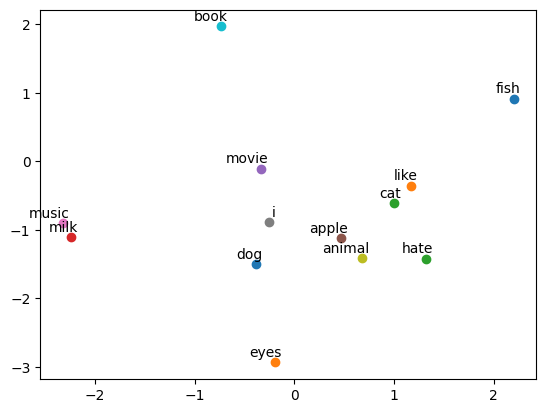

In [10]:
for i, word in enumerate(word_list):
    W, _= model.parameters()
    W = W.detach()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [11]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [12]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


In [13]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]
[521.0674123764038, 518.4512684345245, 515.8549995422363, 513.2761495113373, 510.7138845920563, 508.1685881614685, 505.63789463043213, 503.12277030944824, 500.62082958221436, 498.13055062294006]
tensor([-0.3868,  0.5466, -0.8017,  0.3022, -2.0318, -1.1063,  0.1580, -0.5974,
        -0.8834,  0.6073], grad_fn=<SelectBackward0>)
